### Text Classification

In [1]:
# !pip install imblearn
# nltk.download()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm, linear_model
from joblib import load, dump
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re
import string

In [2]:
# load dataset
data = pd.read_csv('bbc-text.csv')

data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [3]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [4]:
data['Number_of_words'] = data['text'].apply(lambda x:len(str(x).split()))

In [5]:
data.head()

,category,text,Number_of_words
0,tech,tv future in the hands of viewers with home th...,737
1,business,worldcom boss left books alone former worldc...,300
2,sport,tigers wary of farrell gamble leicester say ...,246
3,sport,yeading face newcastle in fa cup premiership s...,341
4,entertainment,ocean s twelve raids box office ocean s twelve...,260


In [6]:
data['Number_of_words'].describe()

count    2225.000000
mean      390.295281
std       241.753128
min        90.000000
25%       250.000000
50%       337.000000
75%       479.000000
max      4492.000000
Name: Number_of_words, dtype: float64

In [7]:
data[data['Number_of_words']==4492]

,category,text,Number_of_words
408,politics,terror powers expose tyranny the lord chance...,4492


Text(0.5, 1.0, 'frequency distribution of number of words for each text')

<Figure size 1080x720 with 0 Axes>

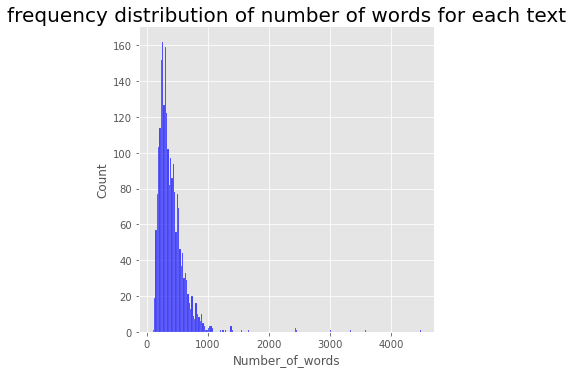

In [8]:
plt.style.use('ggplot')
plt.figure(figsize=(15,10))
sns.displot(data['Number_of_words'], kde = False, color='blue', bins = 200)
plt.title('frequency distribution of number of words for each text', size = 20)

### Data Preprocessing

In [9]:
# here we will lower the text, remove text in square brackets, remove links and remove words contatining numbers.

In [10]:
# cleaning text

# function to clean text

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?]','', text)
    text = re.sub('https?://\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [11]:
# apllying the cleaning function to the dataset

data['cleaned_text'] = data['text'].apply(lambda x: clean_text(x))

In [12]:
data['cleaned_text'].head()

0    tv future in the hands of viewers with home th...
1    worldcom boss  left books alone  former worldc...
2    tigers wary of farrell  gamble  leicester say ...
3    yeading face newcastle in fa cup premiership s...
4    ocean s twelve raids box office ocean s twelve...
Name: cleaned_text, dtype: object

In [13]:
# convert cleaned data to tokens

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
data['tokens'] = data['cleaned_text'].apply(lambda x: tokenizer.tokenize(x))
data.head()

,category,text,Number_of_words,cleaned_text,tokens
0,tech,tv future in the hands of viewers with home th...,737,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with..."
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldc...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary of farrell gamble leicester say ...,"[tigers, wary, of, farrell, gamble, leicester,..."
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ..."


In [14]:
# stopwords

stopwords.words('english')[0:5]

['i', 'me', 'my', 'myself', 'we']

In [15]:
len(stopwords.words('english'))

179

In [16]:
# removing stopwords from sentence

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

In [17]:
data['stopwordremove_tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x))
data.head()

,category,text,Number_of_words,cleaned_text,tokens,stopwordremove_tokens
0,tech,tv future in the hands of viewers with home th...,737,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldc...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary of farrell gamble leicester say ...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, say..."
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe..."


In [18]:
# lemmatization

lem = WordNetLemmatizer()
def lem_word(x):
    return [lem.lemmatize(w) for w in x]

data['lemmatized_text'] = data['stopwordremove_tokens'].apply(lem_word)
data.head()

,category,text,Number_of_words,cleaned_text,tokens,stopwordremove_tokens,lemmatized_text
0,tech,tv future in the hands of viewers with home th...,737,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...","[tv, future, hand, viewer, home, theatre, syst..."
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldc...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, alone, former, w...","[worldcom, bos, left, book, alone, former, wor..."
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary of farrell gamble leicester say ...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, say...","[tiger, wary, farrell, gamble, leicester, say,..."
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, face, newcastle, fa, cup, premiershi...","[yeading, face, newcastle, fa, cup, premiershi..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...","[ocean, twelve, raid, box, office, ocean, twel..."


In [19]:
# combining our text

def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text


In [20]:
data['final_text'] = data['lemmatized_text'].apply(lambda x: combine_text(x))
data.head()

,category,text,Number_of_words,cleaned_text,tokens,stopwordremove_tokens,lemmatized_text,final_text
0,tech,tv future in the hands of viewers with home th...,737,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...","[tv, future, hand, viewer, home, theatre, syst...",tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldc...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, alone, former, w...","[worldcom, bos, left, book, alone, former, wor...",worldcom bos left book alone former worldcom b...
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary of farrell gamble leicester say ...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, say...","[tiger, wary, farrell, gamble, leicester, say,...",tiger wary farrell gamble leicester say rushed...
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, face, newcastle, fa, cup, premiershi...","[yeading, face, newcastle, fa, cup, premiershi...",yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...","[ocean, twelve, raid, box, office, ocean, twel...",ocean twelve raid box office ocean twelve crim...


In [21]:
# checking length of rows after cleaning

data['final_no_of_words'] = data['final_text'].apply(lambda x: len(str(x).split()))
data.head()
                                                     

,category,text,Number_of_words,cleaned_text,tokens,stopwordremove_tokens,lemmatized_text,final_text,final_no_of_words
0,tech,tv future in the hands of viewers with home th...,737,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...","[tv, future, hand, viewer, home, theatre, syst...",tv future hand viewer home theatre system plas...,404
1,business,worldcom boss left books alone former worldc...,300,worldcom boss left books alone former worldc...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, alone, former, w...","[worldcom, bos, left, book, alone, former, wor...",worldcom bos left book alone former worldcom b...,182
2,sport,tigers wary of farrell gamble leicester say ...,246,tigers wary of farrell gamble leicester say ...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, say...","[tiger, wary, farrell, gamble, leicester, say,...",tiger wary farrell gamble leicester say rushed...,129
3,sport,yeading face newcastle in fa cup premiership s...,341,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, face, newcastle, fa, cup, premiershi...","[yeading, face, newcastle, fa, cup, premiershi...",yeading face newcastle fa cup premiership side...,263
4,entertainment,ocean s twelve raids box office ocean s twelve...,260,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...","[ocean, twelve, raid, box, office, ocean, twel...",ocean twelve raid box office ocean twelve crim...,165


In [22]:
data['final_no_of_words'].describe()

count    2225.000000
mean      214.126742
std       123.793680
min        47.000000
25%       139.000000
50%       187.000000
75%       264.000000
max      2191.000000
Name: final_no_of_words, dtype: float64

In [23]:
# # we'll convert our category column into numeric values.
# label_encoder = preprocessing.LabelEncoder()

# # encode labels in category column
# data['target'] = label_encoder.fit_transform(data['category'])

# data['target'].unique()

In [24]:
# Train test split

X = data['final_text']
y = data['category']

X.shape, y.shape

((2225,), (2225,))

In [25]:
# TF-IDF

tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(X)


In [26]:
# tfidf

X_train, X_test, y_train, y_test = train_test_split(tfidf, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1668, 80841), (557, 80841), (1668,), (557,))

In [27]:
# SVM using Stochastic Gradient Descent

svm_classifier = linear_model.SGDClassifier(loss='hinge', alpha=0.0001)

# fitting the model
svm_classifier.fit(X_train, y_train)

# predicting the test results
y_pred = svm_classifier.predict(X_test)

svm_test_accuracy = accuracy_score(y_test, y_pred)

print('Training Accuracy: ', accuracy_score(y_train, svm_classifier.predict(X_train)))
print('Testing Accuracy: ', svm_test_accuracy)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training Accuracy:  1.0
Testing Accuracy:  0.9748653500897666
[[127   1   5   2   1]
 [  0  94   1   0   1]
 [  2   0  96   0   0]
 [  0   0   0 124   0]
 [  0   0   0   1 102]]
               precision    recall  f1-score   support

     business       0.98      0.93      0.96       136
entertainment       0.99      0.98      0.98        96
     politics       0.94      0.98      0.96        98
        sport       0.98      1.00      0.99       124
         tech       0.98      0.99      0.99       103

     accuracy                           0.97       557
    macro avg       0.97      0.98      0.98       557
 weighted avg       0.98      0.97      0.97       557



In [28]:
# text classifier to be used to retrieve our trained data

dump(tfidf_vectorizer, 'processor.joblib')
dump(svm_classifier, 'classifier.joblib')


['classifier.joblib']

In [29]:
processor = load('processor.joblib')
mod = load('classifier.joblib')

# output function

def topic():
    text = input('Enter Search word(s): ')
    text = processor.transform([text])
    predict = mod.predict(text)[0]
    print('This is most likely from {}.'.format(predict))

In [34]:
topic()

This is most likely from entertainment.
